In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
############################# Analise e separação 80 20

# Colunas do adult.data
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income"
]

heart_data = pd.read_csv('./data/heart.csv')
credit_card_data = pd.read_csv('./data/creditcard.csv')
df_adult = pd.read_csv("./data/adult.data", header=None, names=columns, na_values=" ?")

##### Doenças cardiacas
scaler = StandardScaler()
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # Colunas numéricas a serem normalizadas
heart_data[numerical_cols] = scaler.fit_transform(heart_data[numerical_cols])

# Divisão em treino e teste (80%/20%)
X_heart = heart_data.drop('target', axis=1)  # Excluindo a variável alvo
y_heart = heart_data['target']  # Variável alvo
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart, test_size=0.2, random_state=42)

##### Fraudes de cartão de crédito
credit_card_data['Amount'] = scaler.fit_transform(credit_card_data[['Amount']])

# Divisão em treino e teste (80%/20%)
X_credit_card = credit_card_data.drop('Class', axis=1)  # Excluindo a variável alvo
y_credit_card = credit_card_data['Class']  # Variável alvo
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_credit_card, y_credit_card, test_size=0.2, random_state=42)

##### Adult.data
df_adult.dropna(inplace=True)
df_adult['income'] = df_adult['income'].map({' <=50K': 0, ' >50K': 1})
X_adult = df_adult.drop(columns=['income']) # Excluindo a variável alvo
y_adult = df_adult['income'] # Variável alvo
X_adult = pd.get_dummies(X_adult)
scaler = StandardScaler()
X_adult[X_adult.columns] = scaler.fit_transform(X_adult)
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_adult, y_adult, test_size=0.2, random_state=42)

In [14]:
############################# Treinamento

# Função para treinar e avaliar os modelos
def train_and_evaluate_multiple(X_train, X_test, y_train, y_test, model, repetitions=30):
    accuracies = []
    f1_scores = []
    precisions = []
    roc_aucs = []
    
    for _ in range(repetitions):
        model.fit(X_train, y_train)  # Treinar o modelo
        y_pred = model.predict(X_test)  # Fazer previsões
        
        # Avaliar as métricas
        accuracies.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=1))
        roc_aucs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))  # Para ROC-AUC, usamos a probabilidade
    
    return accuracies, f1_scores, precisions, roc_aucs

# Dicionários para armazenar métricas dos modelos
results_heart = {}
results_cc = {}
results_adult = {}

# Definindo os modelos
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1)
}

# Avaliar os modelos para Heart Disease
for model_name, model in models.items():
    acc, f1, prec, roc = train_and_evaluate_multiple(X_train_heart, X_test_heart, y_train_heart, y_test_heart, model)
    results_heart[model_name] = {'Accuracy': acc, 'F1-Score': f1, 'Precision': prec, 'ROC-AUC': roc}

# Avaliar os modelos para Credit Card Fraud Detection
for model_name, model in models.items():
    acc, f1, prec, roc = train_and_evaluate_multiple(X_train_cc, X_test_cc, y_train_cc, y_test_cc, model)
    results_cc[model_name] = {'Accuracy': acc, 'F1-Score': f1, 'Precision': prec, 'ROC-AUC': roc}

# Avaliar os modelos para Adult.data
for model_name, model in models.items():
    acc, f1, prec, roc = train_and_evaluate_multiple(X_train_adult, X_test_adult, y_train_adult, y_test_adult, model)
    results_adult[model_name] = {'Accuracy': acc, 'F1-Score': f1, 'Precision': prec, 'ROC-AUC': roc}

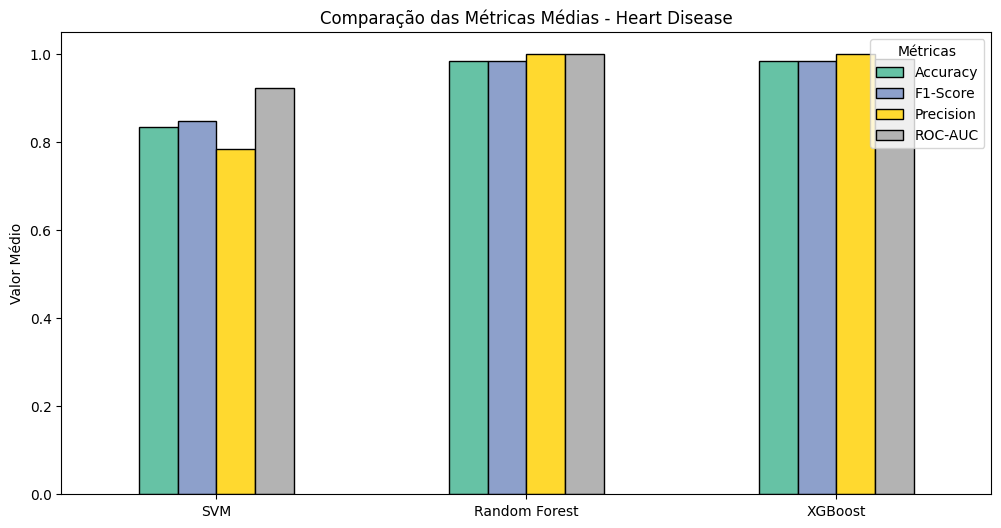

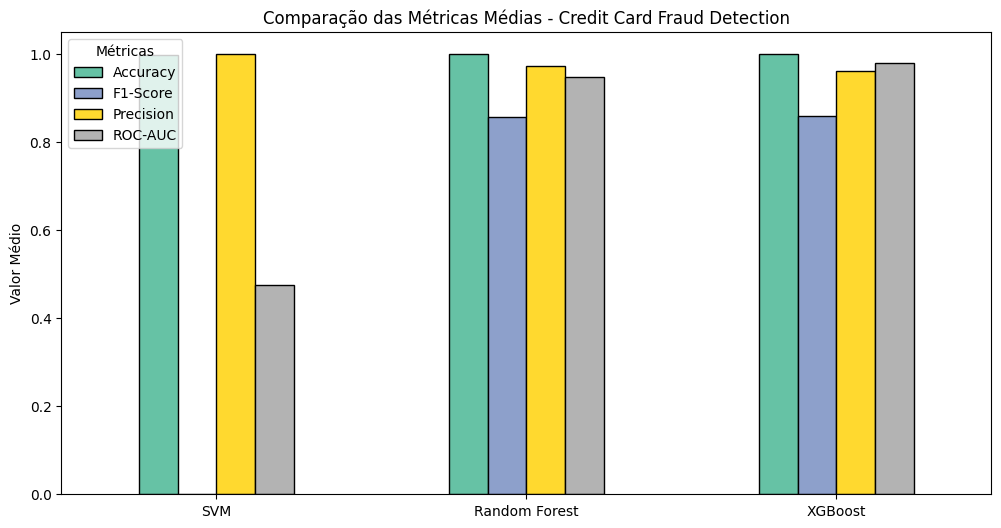

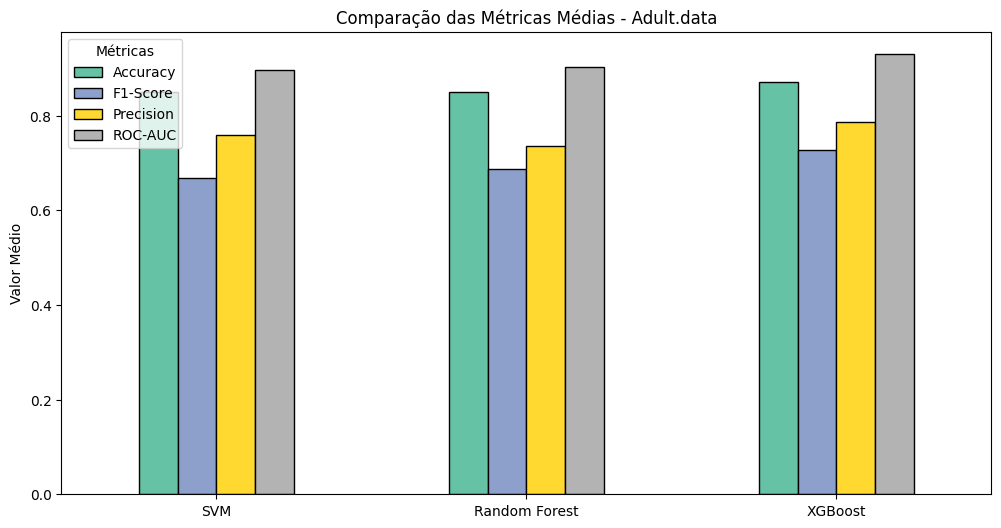

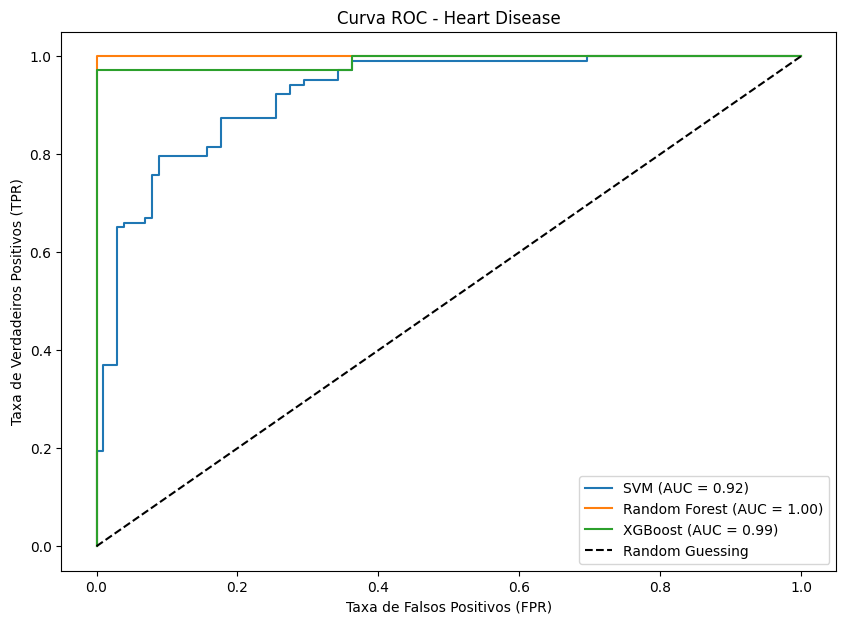

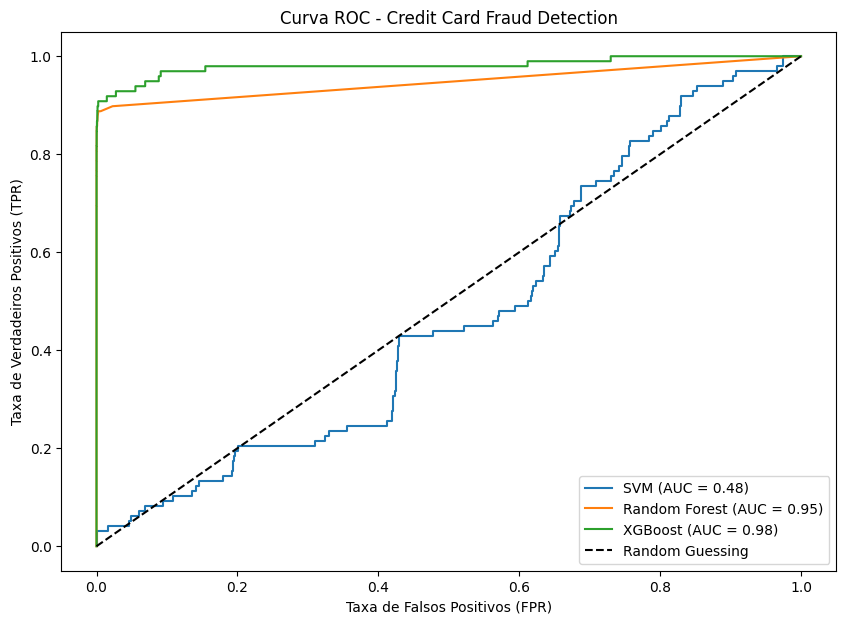

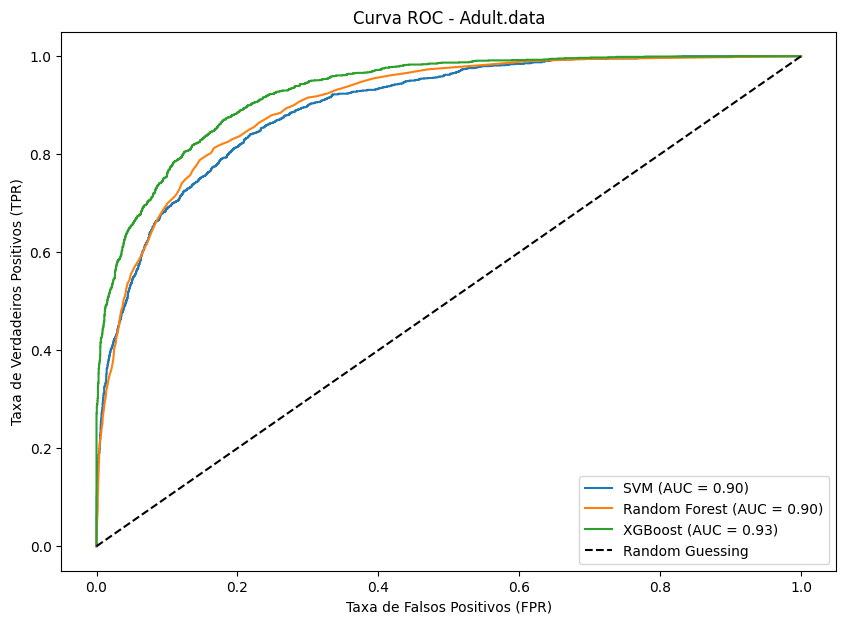

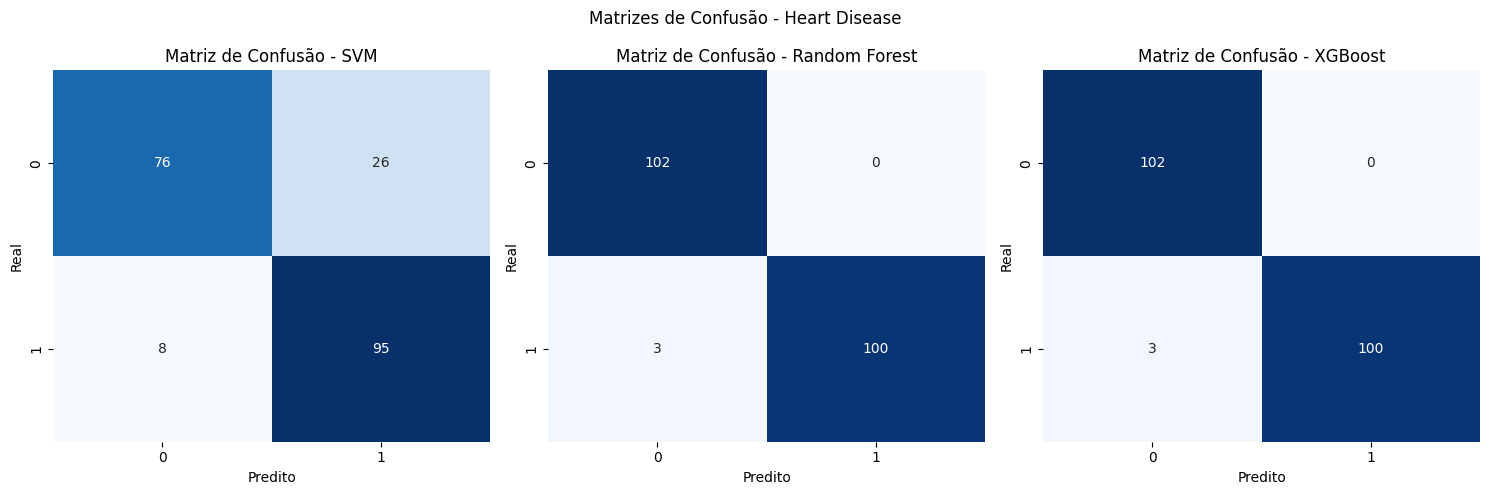

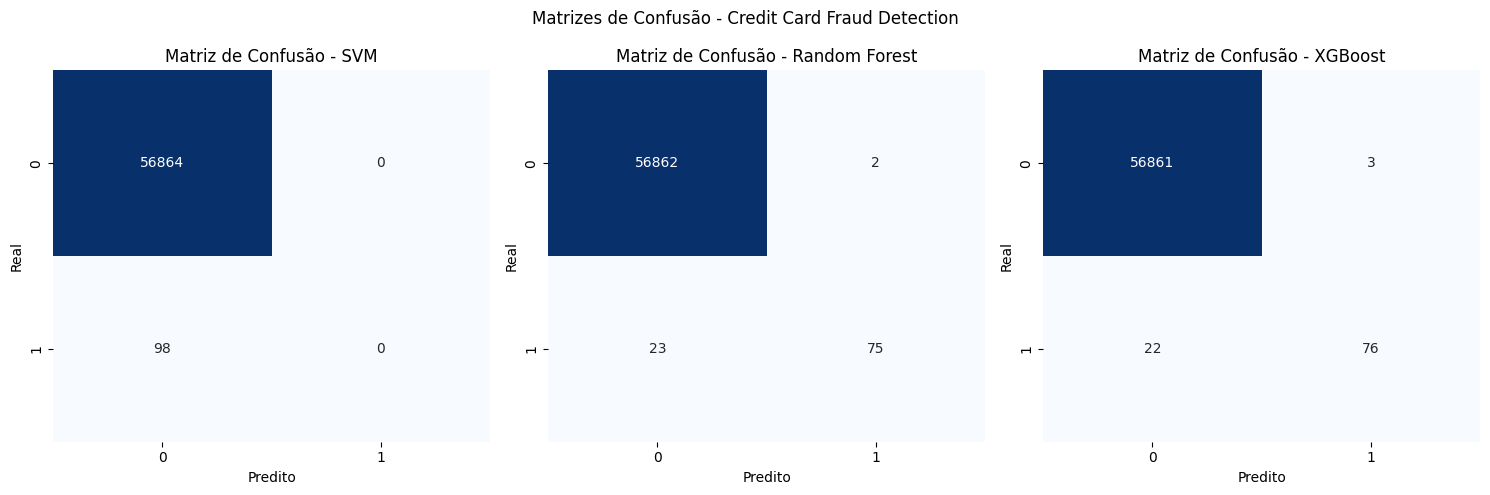

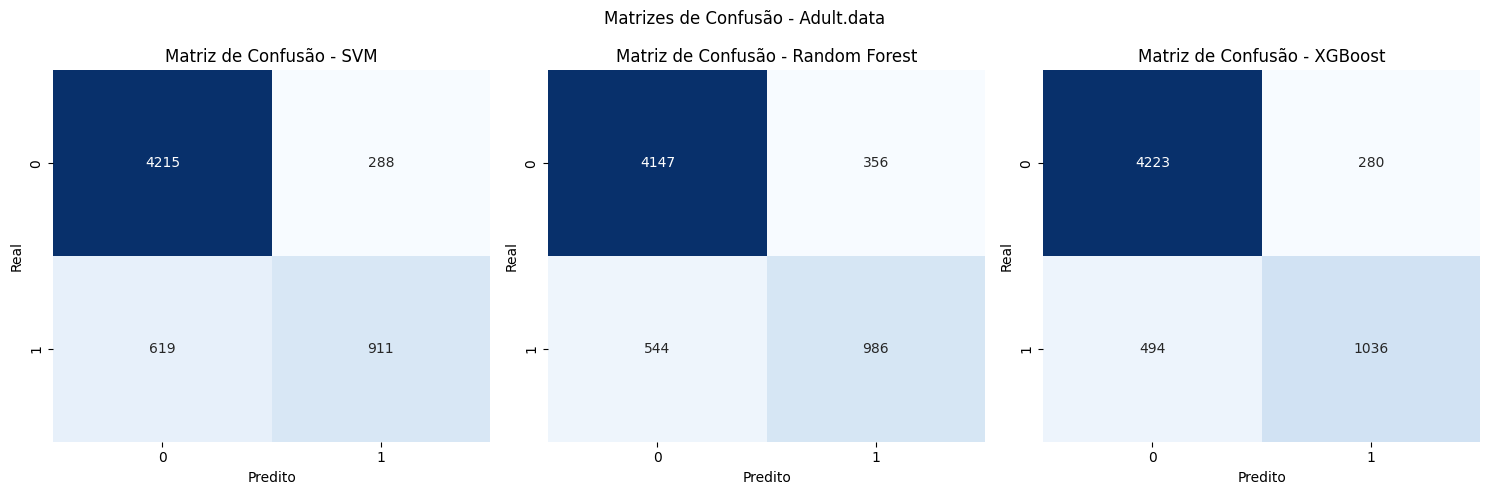

In [15]:
############################# Gráficos

def plot_bar_chart(results, dataset_name):
    avg_metrics = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in results.items()}
    
    metrics_df = pd.DataFrame(avg_metrics).T
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap='Set2', edgecolor='black')
    
    plt.title(f"Comparação das Métricas Médias - {dataset_name}")
    plt.ylabel("Valor Médio")
    plt.xticks(rotation=0)
    plt.legend(title="Métricas")
    plt.show()

def plot_roc_curve(X_train, X_test, y_train, y_test, models, dataset_name):
    plt.figure(figsize=(10, 7))
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
    plt.xlabel("Taxa de Falsos Positivos (FPR)")
    plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
    plt.title(f"Curva ROC - {dataset_name}")
    plt.legend()
    plt.show()

def plot_confusion_matrix(X_train, X_test, y_train, y_test, models, dataset_name):
    plt.figure(figsize=(15, 5))
    
    for i, (model_name, model) in enumerate(models.items(), 1):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        plt.subplot(1, len(models), i)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {model_name}")
    
    plt.suptitle(f"Matrizes de Confusão - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Plotar gráficos de barras
plot_bar_chart(results_heart, "Heart Disease")
plot_bar_chart(results_cc, "Credit Card Fraud Detection")
plot_bar_chart(results_adult, "Adult.data")

# Gerando curvas ROC para ambos os datasets
plot_roc_curve(X_train_heart, X_test_heart, y_train_heart, y_test_heart, models, "Heart Disease")
plot_roc_curve(X_train_cc, X_test_cc, y_train_cc, y_test_cc, models, "Credit Card Fraud Detection")
plot_roc_curve(X_train_adult, X_test_adult, y_train_adult, y_test_adult, models, "Adult.data")

# Gerando matriz de confusão para ambos os datasets
plot_confusion_matrix(X_train_heart, X_test_heart, y_train_heart, y_test_heart, models, "Heart Disease")
plot_confusion_matrix(X_train_cc, X_test_cc, y_train_cc, y_test_cc, models, "Credit Card Fraud Detection")
plot_confusion_matrix(X_train_adult, X_test_adult, y_train_adult, y_test_adult, models, "Adult.data")